<H1> Avaliação de desempenho do modelo </H1>
Objetivo: Avaliação do desempenho do melhor algoritmo escolhdo em MP02;

<p>-> cálculos de sensibilidade e especificidade;
<p>-> matriz de confusão;
<p>-> curvas ROC e AUC; 
<p>-> conclusões acerca da performance do modelo preditivo.

Ref
https://github.com/ishaandey/Classification_Evaluation_Walkthrough/blob/master/Classification_Evaluation.ipynb
https://towardsdatascience.com/credit-card-fraud-detection-a1c7e1b75f59
    

In [80]:
# Basico
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.cm import rainbow
%matplotlib inline
import warnings
import joblib
import pickle
import seaborn as sns
from sklearn.dummy import DummyClassifier
from timeit import default_timer as timer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from inspect import signature
#from pandas_ml import ConfusionMatrix
warnings.filterwarnings('ignore')

<H2>Carga dos Dados</H2>

In [41]:
#CARGA DOS DADOS

data = pd.read_csv(
    "heart-train.csv",           
    na_values=['?']      
)

data['Hospital'] = data.Hospital.str.replace('C', '1')
data['Hospital'] = data.Hospital.str.replace('H', '2')
data['Hospital'] = data.Hospital.str.replace('S', '3')
data['Hospital'] = data.Hospital.str.replace('V', '4')
data['Hospital'] = data.Hospital.astype(int)

data['Sexo'] = data.Sexo.str.replace('F', '1')
data['Sexo'] = data.Sexo.str.replace('M', '2')
data['Sexo'] = data.Sexo.astype(int)

data['Diagnóstico'] = data.Diagnóstico.str.replace('A', '0')
data['Diagnóstico'] = data.Diagnóstico.str.replace('P', '1')
data['Diagnóstico'] = data.Diagnóstico.astype(int)

#dummies 
data = pd.get_dummies(data, columns = ['Sexo'])
#escalar
standardScaler = StandardScaler() #MinMaxScaler()
columns_to_scale = ['TDP', 'PAR','CS', 'ASJ', 'ECG', 'FCM', 'AIE', 'DST', 'IST', 'NVP']
data[columns_to_scale] = standardScaler.fit_transform(data[columns_to_scale])
#para usar depois no REST
scaler_filename = "scaler.save"
joblib.dump(standardScaler, scaler_filename) 

from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(strategy="most_frequent")
data.dtypes
data = data.fillna(data.agg(lambda x: pd.Series.mode(x)[0], axis=0))

# criando a tabela de treinamento e de validação
y = data['Diagnóstico']
X = data.drop(['Diagnóstico'], axis = 1)
X = X.drop(['Paciente'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

In [42]:
data

,Paciente,Hospital,Idade,TDP,PAR,CS,ASJ,ECG,FCM,AIE,DST,IST,NVP,Talassemia,Diagnóstico,Sexo_1,Sexo_2
0,262,1,60,-2.516091,0.979524,0.357099,-0.464095,-0.752935,1.312273,-0.797074,0.026731,-1.245081,-0.729114,3.0,0,1,0
1,520,2,54,0.810358,-0.408751,0.215044,-0.464095,-0.752935,-0.549091,-0.797074,1.028588,0.406727,-0.729114,7.0,1,0,1
2,264,1,61,0.810358,0.313152,-0.299905,-0.464095,1.720415,-0.435130,1.254588,2.485835,0.406727,0.283816,3.0,1,0,1
3,674,3,60,-0.298458,-0.964061,-1.773725,-0.464095,-0.752935,0.248636,-0.797074,1.392900,-1.245081,-0.729114,7.0,1,0,1
4,102,1,57,0.810358,-0.242158,0.916440,-0.464095,1.720415,0.856429,-0.797074,-0.792970,-1.245081,0.283816,3.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,714,3,69,0.810358,-0.686406,-1.773725,-0.464095,0.483740,-0.625065,-0.797074,-0.792970,0.406727,-0.729114,7.0,1,0,1
609,103,1,71,-0.298458,-1.241716,0.579060,2.154729,1.720415,-0.245195,-0.797074,-0.792970,-1.245081,0.283816,3.0,0,1,0
610,854,4,55,0.810358,2.201206,0.534667,-0.464095,-0.752935,-2.410456,-0.797074,1.028588,0.406727,-0.729114,7.0,1,0,1
611,619,3,47,0.810358,-1.241716,-1.773725,-0.464095,0.483740,0.476559,-0.797074,1.119666,-1.245081,-0.729114,7.0,1,0,1


In [43]:
#Showing the breakdown of the distribution of classes

print("Tipos de Diagnósticos")
print(y.value_counts(), end="\n\n")
print("Proporções")
print(y.value_counts()/len(y))

Tipos de Diagnósticos
1    350
0    263
Name: Diagnóstico, dtype: int64

Proporções
1    0.570962
0    0.429038
Name: Diagnóstico, dtype: float64


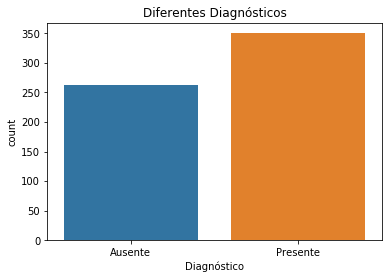

In [44]:
colors = ['red','green']
sns.xkcd_palette(colors)
sns.color_palette(colors)
bp = sns.countplot(x=data["Diagnóstico"])
plt.title("Diferentes Diagnósticos")
bp.set_xticklabels(["Ausente","Presente"])
plt.show()

In [45]:
filename = 'model.pkl'
model = pickle.load(open(filename, 'rb'))
result = model.score(X_test, y_test)
print(result)

0.8325123152709359


In [46]:
model.fit(X_train, y_train)
result = model.score(X_test, y_test)
print(result)

0.8325123152709359


In [51]:
pred = model.predict(X_test)
pred_prob = model.predict_proba(X_test)
#dummy classifier para presente
dummy = DummyClassifier(strategy="most_frequent")
dumb = dummy.fit(X_train,y_train)
dumb_pred = dumb.predict(X_test)
dumb_pred_prob = dumb.predict_proba(X_test)

In [52]:
print("Proporção de previsões como Presente ", pred.mean())
print("Acurácia =", model.score(X_test,y_test), end="\n\n")

#The dummy model predicted that 0% of the data is fraud
print("Proporção de previsões como Presente (Dummy Classifer) = ", dumb_pred.mean())
print("Acurácia (Dummy Classifier) =", dumb.score(dumb_pred,y_test))

Proporção de previsões como Presente  0.5763546798029556
Acurácia = 0.8325123152709359

Proporção de previsões como Presente (Dummy Classifer) =  1.0
Acurácia (Dummy Classifier) = 0.5467980295566502


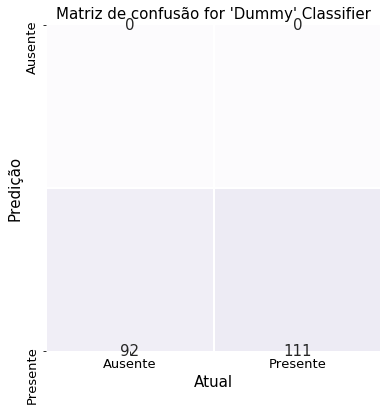

In [64]:
#Building Confusion matrix: Logistic - Thresh=0.5 - Counts
cm_dummy = confusion_matrix(y_test, dumb_pred)
cm_dummy_df = pd.DataFrame(cm_dummy)
fig, ax = plt.subplots(figsize = (6,6))
sns.heatmap(cm_dummy_df.T, annot=True, annot_kws={"size": 15}, cmap="Purples", vmin=0, vmax=800, fmt='.0f', linewidths=1, linecolor="white", cbar=False,
           xticklabels=["Ausente","Presente"], yticklabels=["Ausente","Presente"])
plt.ylabel("Predição", fontsize=15)
plt.xlabel("Atual", fontsize=15)
ax.set_xticklabels(["Ausente","Presente"], fontsize=13)
ax.set_yticklabels(["Ausente","Presente"], fontsize=13)
plt.title("Matriz de confusão for 'Dummy' Classifier", fontsize=15)
plt.show()

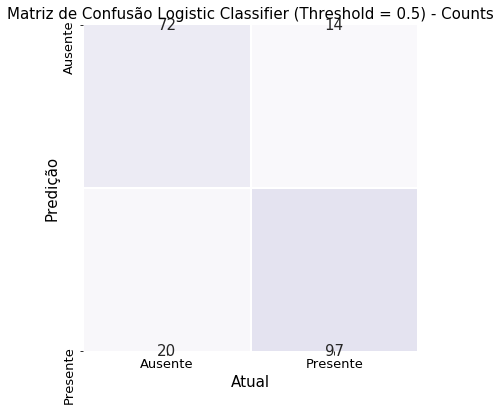

In [67]:
#Building Confusion matrix: Logistic - Thresh=0.5 - Counts
#generate confusion matrix
cm_logis = confusion_matrix(y_test,pred)
#put it into a dataframe
cm_logis_df = pd.DataFrame(cm_logis)
#plot CM
fig, ax = plt.subplots(figsize = (6,6))
sns.heatmap(pd.DataFrame(cm_logis_df.T), annot=True, annot_kws={"size": 15}, cmap="Purples", vmin=0, vmax=500, fmt='.0f', linewidths=1, linecolor="white", cbar=False,
           xticklabels=["Ausente","Presente"], yticklabels=["Ausente","Presente"])
plt.ylabel("Predição", fontsize=15)
plt.xlabel("Atual", fontsize=15)
ax.set_xticklabels(["Ausente","Presente"], fontsize=13)
ax.set_yticklabels(["Ausente","Presente"], fontsize=13)
plt.title("Matriz de Confusão Logistic Classifier (Threshold = 0.5) - Counts", fontsize=15)
plt.show()

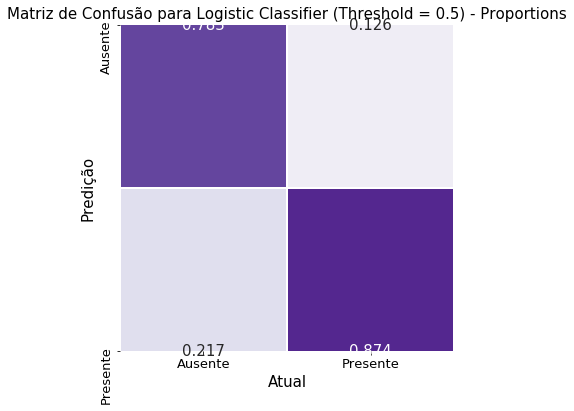

In [68]:
#Generating a Confusion matrix of proportions for logistic model
#converting counts to proportions
cm_logis = cm_logis.astype('float') / cm_logis.sum(axis=1)[:, np.newaxis]
cm_logis_df = pd.DataFrame(cm_logis)
fig, ax = plt.subplots(figsize = (6,6))
sns.heatmap(pd.DataFrame(cm_logis_df.T), annot=True, annot_kws={"size": 15}, cmap="Purples", vmin=0, vmax=1, fmt='.3f', linewidths=1, linecolor="white", cbar=False,
           xticklabels=["Ausente","Presente"], yticklabels=["Ausente","Presente"])
plt.ylabel("Predição", fontsize=15)
plt.xlabel("Atual", fontsize=15)
ax.set_xticklabels(["Ausente","Presente"], fontsize=13)
ax.set_yticklabels(["Ausente","Presente"], fontsize=13)
plt.title("Matriz de Confusão para Logistic Classifier (Threshold = 0.5) - Proportions", fontsize=15)

plt.show()


In [70]:
#generating a report to extract the measure of interest using built-in sklearn function
report = classification_report(y_test,pred,digits=3,output_dict = True)

print("LogReg Model:")
print("Acurácia = {0:0.3f}".format(report["accuracy"]))
print("Precisão = {0:0.3f}".format(report["1"]["precision"]))
print("Especificidade = {0:0.3f}".format(report["1"]["recall"]))
print("Recall = {0:0.3f}".format(report["1"]["recall"]))
print("F1-score = {0:0.3f}".format(report["1"]["f1-score"]))

LogReg Model:
Acurácia = 0.833
Precisão = 0.829
Especificidade = 0.874
Recall = 0.874
F1-score = 0.851


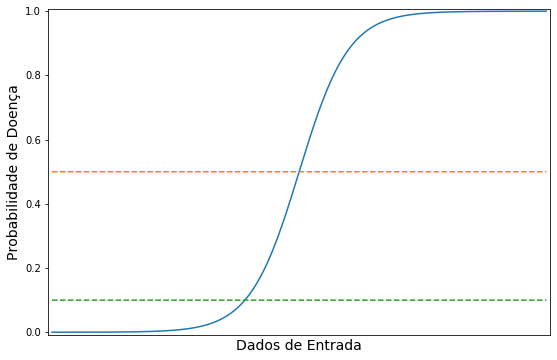

In [71]:
#helper functions
def sigmoid(z):
    sigma = 1 / (1 + np.exp(-z))
    return sigma

def threshold(z,threshold):
    thr = 0*z+threshold
    return thr

#create plot to show how class prediction changes depending on where threshold is set
x_val = np.linspace(-10, 10, 10000)

fig = plt.figure(figsize = (9,6))
plt.plot(x_val, sigmoid(x_val))
plt.plot(x_val, threshold(x_val,0.5), ls='--')
plt.plot(x_val, threshold(x_val,0.1), ls='--')
plt.ylabel('Probabilidade de Doença',size=14)
plt.xlabel('Dados de Entrada',size=14)
ax = plt.gca()
ax.grid(False)
ax.margins(0.008)
ax.get_xaxis().set_ticks([])
plt.show()

In [73]:
#creating new class predictions (from prediction probabilities) with a threshold of 0.1 
pred_logis_1 = (pred_prob[:,1] >= 0.1).astype(int)

#generating another report, this time for threshold = 0.1
report = classification_report(y_test,pred_logis_1,digits=3,output_dict = True)

print("Threshold probability of 0.1:")
print("Acurácia = {0:0.3f}".format(report["accuracy"]))
print("Precisão = {0:0.3f}".format(report["1"]["precision"]))
print("Especificidade = {0:0.3f}".format(report["1"]["recall"]))
print("Recall = {0:0.3f}".format(report["1"]["recall"]))
print("F1-score = {0:0.3f}".format(report["1"]["f1-score"]))

Threshold probability of 0.1:
Acurácia = 0.665
Precisão = 0.621
Especificidade = 0.991
Recall = 0.991
F1-score = 0.764


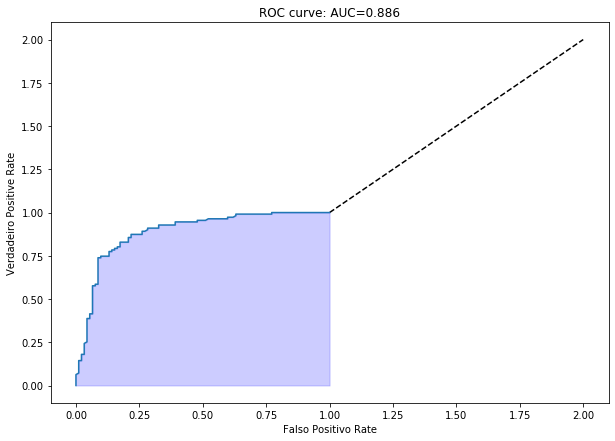

In [77]:
#Plotting the ROC curve

#Generating points to plot on ROC curve (logistic model)
fpr_logis, tpr_logis, thresholds_logis = roc_curve(y_test, pred_prob[:,1])
fig, ax = plt.subplots(figsize = (10,7))
#plotting the "guessing" model
plt.plot([1, 2], [1, 2], 'k--')
#plotting the logistic model
plt.plot(fpr_logis, tpr_logis)
plt.fill_between(fpr_logis, tpr_logis, alpha=0.2, color='b')
plt.xlabel('Falso Positivo Rate')
plt.ylabel('Verdadeiro Positive Rate')
plt.title('ROC curve: AUC={0:0.3f}'.format(roc_auc_score(y_test,pred_prob[:,1])))
plt.show()

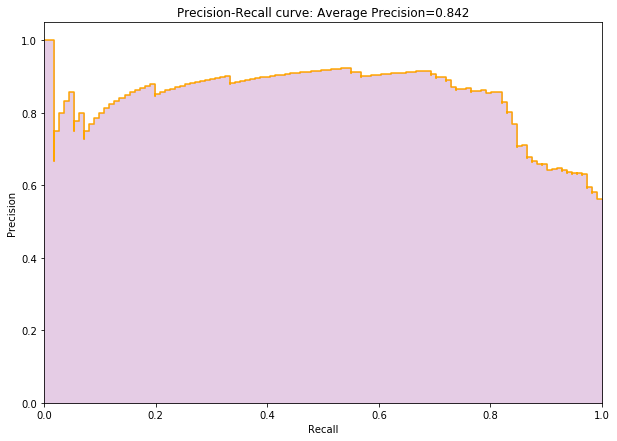

In [82]:
#Plot PR curve

#Generating points to plot on recall precision curve
precision, recall, thresholds = precision_recall_curve(y_test, logis_pred_prob[:,1])
average_precision = average_precision_score(y_test, logis_pred_prob[:,1])

#its a step function so plotting is different 
fig, ax = plt.subplots(figsize = (10,7))
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='orange', alpha=1,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='purple', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision={0:0.3f}'.format(average_precision))
plt.show()